In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import scipy.stats
from scipy.stats import mstats
import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Восстановление данных

## Чтение Данных

In [2]:
# 1. Чтение данных 
try:
    conn = sqlite3.connect('shop_database.db')  
    personal_data_db = pd.read_sql_query("SELECT * FROM personal_data", conn)
    conn.close()
except Exception as e:
    print(f"Ошибка при чтении данных из базы данных: {e}")
    personal_data_db = pd.DataFrame()

try:
    personal_data_csv = pd.read_csv("personal_data.csv.gz")
except FileNotFoundError:
    print("Ошибка: Файл personal_data.csv.gz не найден.")
    personal_data_csv = pd.DataFrame()
except Exception as e:
    print(f"Ошибка при чтении файла CSV: {e}")
    personal_data_csv = pd.DataFrame()

if not personal_data_db.empty and not personal_data_csv.empty:
    common_column = 'id' 

    personal_data_db['source'] = 'database'
    personal_data_csv['source'] = 'csv'

    personal_data_combined = pd.concat([personal_data_db, personal_data_csv], ignore_index=True)

    if common_column in personal_data_combined.columns:
        personal_data_combined = personal_data_combined.drop_duplicates(subset=[common_column], keep='last')
    else:
        print(f"Предупреждение: Столбец '{common_column}' не найден.  Невозможно удалить дубликаты.")

    # Удаляем столбец 'source' до обучения
    if 'source' in personal_data_combined.columns:
        personal_data_combined = personal_data_combined.drop('source', axis=1)

else:
    if personal_data_db.empty:
        personal_data_combined = personal_data_csv.copy()
    elif personal_data_csv.empty:
        personal_data_combined = personal_data_db.copy()
    else:
        personal_data_combined = pd.DataFrame()

## Подготовка данных для машинного обучения с целью восстановления информации о поле клиента

In [3]:
# 2. Подготовка данных для машинного обучения

# Удаляем строки с пропущенным полом (они нужны только для обучения модели)
personal_data_train = personal_data_combined.dropna(subset=['gender']).copy()

# Заполняем 'gender' в основном DataFrame, но только после обучения!
personal_data_to_predict = personal_data_combined[personal_data_combined['gender'].isnull()].copy()

# Проверяем, что после удаления строк с NaN в 'gender', осталось что-то для обучения
if personal_data_train.empty:
    print("Ошибка: Нет данных для обучения модели.  Проверьте наличие информации о поле клиентов в базе данных и CSV-файле.")
    exit()  # Завершаем работу скрипта

# Кодируем категориальные признаки (кроме gender, его кодируем позже)
categorical_features = [col for col in personal_data_train.columns if personal_data_train[col].dtype == 'object' and col != 'gender']
for col in categorical_features:
    le = LabelEncoder()
    personal_data_train[col] = le.fit_transform(personal_data_train[col])
    # Важно: Применяем то же преобразование к данным для предсказания
    if col in personal_data_to_predict.columns: # Проверяем, что столбец существует
        personal_data_to_predict[col] = le.transform(personal_data_to_predict[col])


# Кодируем целевую переменную 'gender'
label_encoder = LabelEncoder()
personal_data_train['gender'] = label_encoder.fit_transform(personal_data_train['gender'])

# Определяем признаки и целевую переменную
X = personal_data_train.drop('gender', axis=1)
y = personal_data_train['gender']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Обучение и оценка модели 

In [4]:
# 3. Обучение модели
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [5]:
# 4. Оценка модели
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели: {accuracy}")
print(classification_report(y_test, y_pred))

Точность модели: 0.5395260238668833
              precision    recall  f1-score   support

           0       0.46      0.43      0.45      7717
           1       0.59      0.62      0.61     10132

    accuracy                           0.54     17849
   macro avg       0.53      0.53      0.53     17849
weighted avg       0.54      0.54      0.54     17849



## Предсказание пола для клиентов с утерянными данными

In [6]:
# 5. Предсказание пола для клиентов с утерянными данными
if not personal_data_to_predict.empty:

    # Убедимся, что в данных для предсказания есть те же столбцы, что и в обучающих данных
    missing_cols = set(X_train.columns) - set(personal_data_to_predict.columns)
    for c in missing_cols:
        personal_data_to_predict[c] = 0 # Заполняем нулями отсутствующие столбцы

    # И наоборот, удаляем столбцы, которых нет в обучающих данных
    extra_cols = set(personal_data_to_predict.columns) - set(X_train.columns)
    for c in extra_cols:
        personal_data_to_predict = personal_data_to_predict.drop(c, axis=1)

    # Упорядочиваем столбцы, чтобы они соответствовали порядку обучающих данных
    personal_data_to_predict = personal_data_to_predict[X_train.columns]

    # Предсказываем пол
    predicted_gender = model.predict(personal_data_to_predict)

    # Обратное преобразование численных меток в строковые значения пола
    predicted_gender_labels = label_encoder.inverse_transform(predicted_gender)

    # Присваиваем предсказанные значения пола соответствующим клиентам
    personal_data_combined.loc[personal_data_combined['gender'].isnull(), 'gender'] = predicted_gender_labels

    print("\nПредсказанные значения пола:")
    print(personal_data_combined[personal_data_combined['gender'].isin(label_encoder.classes_)]['gender'].value_counts())

else:
    print("\nНет данных для предсказания пола.")


Предсказанные значения пола:
gender
1.0    60572
0.0    44417
Name: count, dtype: int64


## Вывод обновленных данных

In [7]:
# 6. Вывод обновленных данных
print("\nОбновленные данные с восстановленным полом:")
print(personal_data_combined)


Обновленные данные с восстановленным полом:
            id  gender  age education  city  country
0            0     0.0   36   среднее  1201       32
1            4     0.0   35   среднее  1134       32
2            6     1.0   52   среднее  1188       32
3            7     0.0   37   среднее  1198       32
4            9     0.0   48   среднее  1134       32
...        ...     ...  ...       ...   ...      ...
104984  135183     0.0   44   среднее  1134       32
104985  125993     0.0   46   среднее  1134       32
104986  167019     0.0   71   среднее  1134       32
104987  116355     1.0   32   среднее  1188       32
104988   15885     0.0   33   среднее  1190       32

[104989 rows x 6 columns]


# Сохранение полных данных в CSV

In [8]:
personal_data_combined.to_csv("personal_data_полностью.csv", index=False) #  Сохраняем в CSV

# Подготовка данных

## Запись таблицы с восстановленными данными в нашу БД(сразу с фильтрацией по стране 32)

In [9]:
# Имя файла базы данных SQLite (в той же директории)
db_file = "shop_database.db"  

# Имя CSV файла
csv_file = "personal_data_полностью.csv"

# Код страны для фильтрации
country_code = 32

try:
    # Устанавливаем соединение с базой данных SQLite
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()

    # Читаем CSV файл с помощью pandas
    df = pd.read_csv(csv_file)

    # Фильтруем DataFrame по коду страны
    df_filtered = df[df['country'] == country_code]

    # Получаем имя таблицы, в которую будем импортировать данные
    table_name = "personal_data_country_32"  

    # Создаем таблицу, если она не существует (автоматически определяем типы данных на основе DataFrame)
    

    # Определяем типы данных для столбцов 
    column_types = []
    for col in df_filtered.columns:
        if df_filtered[col].dtype == 'int64':
            column_types.append(f"{col} INTEGER")
        elif df_filtered[col].dtype == 'float64':
            column_types.append(f"{col} REAL") 
        elif df_filtered[col].dtype == 'bool':
            column_types.append(f"{col} INTEGER") 
        else:  
            column_types.append(f"{col} TEXT")

    create_table_sql = f"CREATE TABLE IF NOT EXISTS {table_name} ({', '.join(column_types)});"

    cur.execute(create_table_sql)
    conn.commit()


    # Вставляем данные в таблицу
    df_filtered.to_sql(table_name, conn, if_exists='append', index=False)

    conn.commit()  # Фиксируем изменения
    print(f"Успешно импортировано {len(df_filtered)} строк в таблицу {table_name} (только для country_code = {country_code})")

except Exception as e:
    print(f"Ошибка подключения к базе данных или импорта: {e}")

finally:
    # Закрываем соединение
    if conn:
        cur.close()
        conn.close()

Успешно импортировано 104437 строк в таблицу personal_data_country_32 (только для country_code = 32)


## Запись трех таблиц, необходимых для анализа

In [10]:
# 1. Подключение к базе данных SQLite
db_path = 'shop_database.db'  

try:
    conn = sqlite3.connect(db_path)
    print("Успешно подключились к базе данных SQLite")
except sqlite3.Error as e:
    print(f"Ошибка при подключении к базе данных SQLite: {e}")
    exit()

# 2. Загрузка данных из таблиц SQLite в Pandas DataFrame
def load_table_to_dataframe(table_name, connection):
    try:
        query = f"SELECT * FROM {table_name}"  # SQL запрос для выбора всех данных из таблицы
        df = pd.read_sql_query(query, connection)  # Загружаем данные в DataFrame
        print(f"Успешно загрузили таблицу '{table_name}' в DataFrame")
        return df
    except pd.io.sql.DatabaseError as e:
        print(f"Ошибка при загрузке таблицы '{table_name}': {e}")
        return None

df_personal = load_table_to_dataframe('personal_data_country_32', conn)
df_coeffs = load_table_to_dataframe('personal_data_coeffs', conn)
df_purchases = load_table_to_dataframe('purchases', conn)

# Закрываем соединение с базой данных после загрузки таблиц
conn.close()
print("Закрыли соединение с базой данных")

# Проверка успешности загрузки данных
if df_personal is None or df_coeffs is None or df_purchases is None:
    print("Не удалось загрузить все таблицы. Завершаем работу.")
    exit()

Успешно подключились к базе данных SQLite
Успешно загрузили таблицу 'personal_data_country_32' в DataFrame
Успешно загрузили таблицу 'personal_data_coeffs' в DataFrame
Успешно загрузили таблицу 'purchases' в DataFrame
Закрыли соединение с базой данных


## Объединение данных

In [11]:
# 3. Объединение данных

# Переименовываем столбец 'client_id' в 'id' в df_coeffs
df_coeffs.rename(columns={'client_id': 'id'}, inplace=True)

# Проверяем наличие столбцов 'id' (уже после переименования)
print(f"Columns in df_personal: {df_personal.columns}")
print(f"Columns in df_coeffs: {df_coeffs.columns}")
print(f"Columns in df_purchases: {df_purchases.columns}")


df_personal['id'] = df_personal['id'].astype(int)
df_coeffs['id'] = df_coeffs['id'].astype(int)

# Добавляем personal_coef
df = pd.merge(df_personal, df_coeffs, on='id', how='left')

# Добавляем данные о покупках (левое соединение, чтобы сохранить всех клиентов)
df = pd.merge(df, df_purchases, left_on='id', right_on='id', how='left')

Columns in df_personal: Index(['id', 'gender', 'age', 'education', 'city', 'country'], dtype='object')
Columns in df_coeffs: Index(['id', 'lbt_coef', 'ac_coef', 'sm_coef', 'personal_coef'], dtype='object')
Columns in df_purchases: Index(['id', 'product', 'colour', 'cost', 'product_sex', 'base_sale', 'dt'], dtype='object')


In [12]:
df = df.drop('country', axis=1) #Удаляем колонку, так как ранее отфильтровали по стране 32 и далее работаем только с этими данными

## Стандартизация названий товаров

In [13]:
# --- 2. Стандартизация названий товаров ---

print("\nСтандартизация названий товаров...")
def standardize_product_name(name):
    """Приводит названия товаров к единому формату."""
    if isinstance(name, str):  # обработка возможных нестроковых значений
        name = name.lower().strip()  # Приведение к нижнему регистру и удаление пробелов
        name = name.replace("t-shirt", "tshirt")
        return name
    else:
        return str(name) 

df['product'] = df['product'].apply(standardize_product_name)

#  Посмотрим уникальные значения до и после стандартизации
print("Уникальные названия товаров до стандартизации:", df['product'].nunique())
print("Уникальные названия товаров после стандартизации:", df['product'].nunique())
print("Примеры стандартизированных названий:", df['product'].unique()[:10])  # Вывод первых 10 уникальных


Стандартизация названий товаров...
Уникальные названия товаров до стандартизации: 22778
Уникальные названия товаров после стандартизации: 22778
Примеры стандартизированных названий: ['велосипед горный женский stern mira 2.0 26"' 'стол outventure'
 'набор outventure: стол + 4 стула'
 'роликовые коньки детские roces orlando iii' 'шлем fila nrk fun'
 'роликовые коньки детские roces yuma tif'
 'набор защиты из 3-х предметов детский reaction rainbow'
 'шлем для девочек reaction urban'
 'роликовые коньки детские раздвижные reaction rainbow'
 'куртка утепленная для девочек outventure']


## Обработка написания цветов

In [14]:
print("\nОбработка цветов...")

def clean_colors(color_string):
    """Заменяет '/' на '_' в строке с цветами и приводит к нижнему регистру."""
    if isinstance(color_string, str):
        return color_string.lower().strip().replace('/', '_')
    else:
        return str(color_string)  

# Применяем функцию к столбцу 'color'
df['colour'] = df['colour'].apply(clean_colors)

# Посмотрим уникальные значения
print("Уникальные цвета после очистки:", df['colour'].unique())



Обработка цветов...
Уникальные цвета после очистки: ['белый_синий' 'зелёный' 'бежевый' ... 'св.розовый'
 'ярко-розовый_мультицвет' 'черный_коралловый_серый']


## Обработка пропусков

In [15]:
# 1. Обнаружение пропущенных значений (NaN)

# Вывод количества пропущенных значений в каждом столбце
print("Количество пропущенных значений до обработки:\n", df.isnull().sum())

# 2. Заполнение пропущенных значений модой (и изменение для product_sex)

# Функция для заполнения пропущенных значений модой
def fill_missing_with_mode(df):
    """Заполняет пропущенные значения в DataFrame модой для каждого столбца,
       кроме 'product_sex', для которого заполняет значением 2.

    Args:
        df (pd.DataFrame): DataFrame, в котором нужно заполнить пропуски.

    Returns:
        pd.DataFrame: DataFrame с заполненными пропущенными значениями.
    """
    for column in df.columns:
        if column == 'product_sex':
            df[column] = df[column].fillna(2)  # Заполняем 'product_sex' значением 2
        else:
            # Вычисляем моду для текущего столбца
            mode = df[column].mode()[0]  # mode() возвращает Series, берем первый элемент
            # Заполняем пропущенные значения модой
            df[column] = df[column].fillna(mode)
    return df

# Применяем функцию к DataFrame
df = fill_missing_with_mode(df)



# 3. Проверка на наличие оставшихся пропущенных значений

print("\nКоличество пропущенных значений после обработки:\n", df.isnull().sum())

Количество пропущенных значений до обработки:
 id                      0
gender                  0
age                     0
education               0
city                    0
lbt_coef                0
ac_coef                 0
sm_coef                 0
personal_coef           0
product                 0
colour                  0
cost                    0
product_sex      12190503
base_sale               0
dt                      0
dtype: int64

Количество пропущенных значений после обработки:
 id               0
gender           0
age              0
education        0
city             0
lbt_coef         0
ac_coef          0
sm_coef          0
personal_coef    0
product          0
colour           0
cost             0
product_sex      0
base_sale        0
dt               0
dtype: int64


## Замена значений образования на булевы значения

In [16]:
df['education'].unique()

array(['среднее', 'высшее'], dtype=object)

In [18]:
df['education'] = df['education'].replace({'среднее': 0, 'высшее': 1})

## Анализ и обработка выбросов

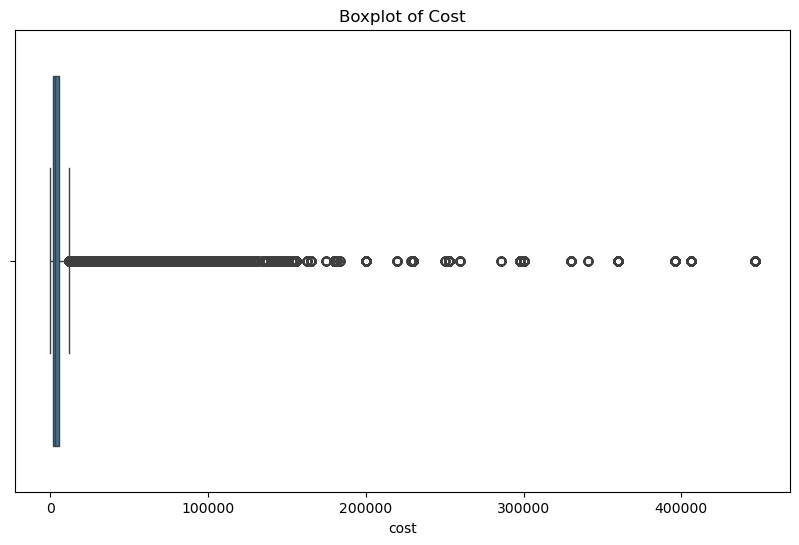

In [19]:
# Анализ выбросов ( для колонки 'cost')
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['cost'])
plt.title('Boxplot of Cost')
plt.show()

In [20]:
# Определение выбросов и их индексов на основе 0.05 и 0.95 квантилей
Q1 = df['cost'].quantile(0.05)  
Q3 = df['cost'].quantile(0.95)  
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Находим индексы строк, где 'cost' выходит за границы
outlier_indices = df[(df['cost'] < lower_bound) | (df['cost'] > upper_bound)].index

# Выводим строки с выбросами
outliers_df = df.loc[outlier_indices]
outliers_df

,id,gender,age,education,city,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
66,13,0.0,40,0,1155,5.425974,0.184436,0.663517,0.5072,палатка 2-местная jack wolfskin lighthouse ii rt,синий,122499,2.0,0,28
67,13,0.0,40,0,1155,5.425974,0.184436,0.663517,0.5072,спальный мешок mountain hardwear phantom -12 л...,красный,58499,2.0,0,28
175,50,0.0,41,0,1172,4.886085,0.578484,1.422474,0.5072,палатка 3-местная marmot tungsten ul 3p,зелёный,120999,2.0,0,0
493,143,1.0,34,0,1201,7.700899,0.443268,0.634637,0.4304,беговая дорожка torneo nota t-310,графитовый,49999,2.0,0,57
609,201,1.0,21,1,1180,6.793119,0.273458,0.739793,0.4688,"велосипед горный trek marlin 5 29"", 2021",черный,59499,2.0,0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30424128,127501,1.0,33,0,1155,7.351032,-0.052052,0.745113,0.4304,электрический велосипед унисекс для взрослых b...,None,89670,2.0,0,37
30424129,127501,1.0,33,0,1155,7.351032,-0.052052,0.745113,0.4304,палатка 2-местная kailas dragonfly cuben 2p,оранжевый,99999,2.0,0,37
30424507,118249,1.0,47,0,1157,7.725892,-0.114636,0.762520,0.4304,"велосипед гравийный roces sole 2 28""",темно-синий,64999,2.0,0,8
30424508,118249,1.0,47,0,1157,7.725892,-0.114636,0.762520,0.4304,"байдарка вольный ветер ""одиссей 370"", красный",красный,44500,2.0,0,30


Выбросы для колонки 'cost' оставляем без изменений. После просмотра строк, попавших в выбросы, мы видим, что такие цены действительно имеют место быть.

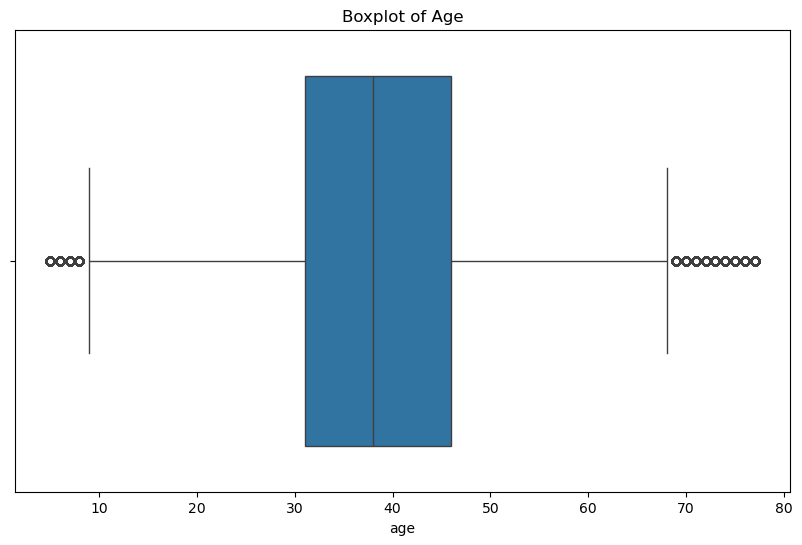

In [21]:
# Анализ выбросов ( для колонки 'age')
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['age'])
plt.title('Boxplot of Age')
plt.show()

In [22]:
# Определение выбросов и их индексов
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Находим индексы строк, где 'age' выходит за границы
outlier_indices = df[(df['age'] < lower_bound) | (df['age'] > upper_bound)].index

# Выводим строки с выбросами
outliers_df = df.loc[outlier_indices]
outliers_df

,id,gender,age,education,city,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
1821,574,0.0,71,0,1168,5.756485,0.120071,1.490797,0.5072,ботинки горнолыжные head edge lyt 130 gw,None,42999,2.0,0,1
1845,585,1.0,5,0,1152,6.007665,-0.200491,1.248311,0.2576,футболка женская demix,черный,699,0.0,1,7
1846,585,1.0,5,0,1152,6.007665,-0.200491,1.248311,0.2576,легинсы женские demix,синий,1609,0.0,1,7
1847,585,1.0,5,0,1152,6.007665,-0.200491,1.248311,0.2576,кеды мужские reebok royal complete cln2,белый,4799,1.0,1,11
1848,585,1.0,5,0,1152,6.007665,-0.200491,1.248311,0.2576,кресло кемпинговое outventure,бежевый,4499,2.0,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30424541,167019,0.0,71,0,1134,6.172481,0.354901,1.491271,0.5072,рубашка с коротким рукавом женская termit,синий_зеленый,1999,0.0,0,6
30424542,167019,0.0,71,0,1134,6.172481,0.354901,1.491271,0.5072,газовый баллон kovea,белый,699,2.0,0,20
30424543,167019,0.0,71,0,1134,6.172481,0.354901,1.491271,0.5072,лонгслив мужской termit,черный,979,1.0,1,20
30424544,167019,0.0,71,0,1134,6.172481,0.354901,1.491271,0.5072,брюки мужские fila,черный,2449,1.0,1,20


In [23]:
# Удаление выбросов ( для колонки 'age') 

df = df[(df['age'] >= lower_bound)]

Выбросы для колонки 'age' убираем только значения меньшие низшей границы. Люди старшей возрастной категории - это явление допустимое, а вот совсем маленькие дети, расплачивающиеся в магазине - это аномалия.

# Итоговый датафрейм

In [24]:
df

,id,gender,age,education,city,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
0,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,"велосипед горный женский stern mira 2.0 26""",белый_синий,13599,0.0,1,7
1,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,стол outventure,зелёный,1499,2.0,0,37
2,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,набор outventure: стол + 4 стула,бежевый,4799,2.0,0,37
3,4,0.0,35,0,1134,4.569378,0.063693,0.820892,0.5072,роликовые коньки детские roces orlando iii,черный_розовый,9199,2.0,0,0
4,4,0.0,35,0,1134,4.569378,0.063693,0.820892,0.5072,шлем fila nrk fun,белый,4999,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30424558,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,поло мужское outventure,синий,1599,1.0,0,24
30424559,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,майка мужская babolat complete muscle,оранжевый_синий,3899,1.0,0,24
30424560,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,майка мужская protest prtihiaka,белый_принт,1679,1.0,1,49
30424561,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,массажер demix,темно-зелёный,399,2.0,0,52


In [25]:
df.to_csv('final.csv', index=False)
print("DataFrame сохранен в файл final.csv")

DataFrame сохранен в файл final.csv


# 1. Анализ эффективности первой маркетинговой компании

Известно, что магазин проводил две маркетинговые кампании: 

Первая кампания проводилась в период с 5-го по 16-й день, ID участвовавших в ней пользователей содержатся в файле ids_first_company_positive.txt. Эта кампания включала в себя предоставление персональной скидки 5 000 клиентов через email-рассылку.
Вторая кампания проводилась на жителях города 1 134 и представляла собой баннерную рекламу на билбордах: скидка всем каждое 15-е число месяца (15-й и 45-й день в нашем случае).
Заказчик просит вас проанализировать, насколько первая маркетинговая кампания была эффективна. Для проведения A/B-тестирования, помимо людей, которым предлагалась персональная скидка, были отобраны люди со схожими социально-демографическими признаками и покупками, которым скидку не предложили. ID этих клиентов лежат в аналогичном файле ids_first_company_negative.txt. Проведите расчёт A/B-теста и посчитайте значения основных метрик. Потом сделайте бизнес-рекомендацию и обоснуйте её. 

## Загрузка ID пользователей, участвующих в компании и обработка данных

### Загрузка ID пользователей из текстовых файлов

In [26]:
# Загрузка ID пользователей из текстовых файлов
with open("ids_first_company_positive.txt", "r") as f:
    f.readline()  # Пропускаем первую строку (заголовок)
    line = f.readline()  # Читаем вторую строку (с ID)
    line = line.replace(';', ',')  # Заменяем точки с запятой на запятые
    ids_positive = [int(id.strip()) for id in line.split(',') if id.strip()]

with open("ids_first_company_negative.txt", "r") as f:
    f.readline()  # Пропускаем первую строку (заголовок)
    line = f.readline()  # Читаем вторую строку (с ID)
    line = line.replace(';', ',')  # Заменяем точки с запятой на запятые
    ids_negative = [int(id.strip()) for id in line.split(',') if id.strip()]

In [27]:
print(f"Количество пользователей в положительной группе: {len(ids_positive)}")
print(f"Количество пользователей в отрицательной группе: {len(ids_negative)}")

Количество пользователей в положительной группе: 158
Количество пользователей в отрицательной группе: 158


### Фильтрация по дате (dt от 5 до 16 включительно)

In [28]:
# Фильтрация по дате (dt от 5 до 16 включительно)
df_filtered = df[(df['dt'] >= 5) & (df['dt'] <= 16)]

### Исключаем пользователей, попавших под вторую кампанию: город 1134 и dt=15

In [29]:
# Исключаем пользователей, попавших под вторую кампанию: город 1134 и dt=15
ids_to_exclude = df[(df['city'] == 1134) & (df['dt'] == 15)]['id'].tolist()
print(f"Исключаем ID: {ids_to_exclude}")
# Фильтруем эти id из обоих датафреймов (перед фильтрацией по positive/negative id)
df_filtered = df_filtered[~df_filtered['id'].isin(ids_to_exclude)]

Исключаем ID: [101, 105, 130, 148, 148, 168, 176, 225, 267, 287, 287, 310, 311, 315, 315, 317, 361, 464, 481, 538, 560, 560, 560, 705, 705, 759, 802, 802, 802, 802, 824, 824, 838, 838, 892, 944, 944, 998, 1154, 1168, 1168, 1238, 1238, 1238, 1238, 1278, 1324, 1324, 1338, 1391, 1457, 1457, 1457, 1457, 1457, 1489, 1489, 1489, 1489, 1489, 1491, 1512, 1540, 1610, 1627, 1680, 1747, 1767, 1767, 1786, 1891, 1891, 1891, 1954, 1959, 1984, 1984, 2061, 2061, 2061, 2061, 2061, 2181, 2181, 2181, 2265, 2295, 2319, 2331, 2373, 2373, 2373, 2399, 2421, 2485, 2485, 2571, 2589, 2665, 2665, 2769, 2769, 2769, 2769, 2770, 2770, 2779, 2883, 2933, 2933, 2937, 2957, 2957, 2957, 2957, 2957, 3001, 3007, 3063, 3151, 3151, 3175, 3176, 3176, 3192, 3216, 3216, 3248, 3271, 3271, 3271, 3283, 3306, 3435, 3435, 3435, 3444, 3449, 3449, 3541, 3541, 3618, 3710, 3710, 3747, 3765, 3805, 3839, 3883, 4031, 4031, 4031, 4031, 4031, 4201, 4201, 4201, 4201, 4201, 4220, 4220, 4220, 4220, 4220, 4274, 4274, 4296, 4296, 4317, 4414, 441

### Фильтрация по ID пользователей для обеих групп

In [30]:
# Фильтрация по ID пользователей для обеих групп
df_positive = df_filtered[df_filtered['id'].isin(ids_positive)]
df_negative = df_filtered[df_filtered['id'].isin(ids_negative)]

print(f"Размер положительной группы после фильтрации: {df_positive.shape}")
print(f"Размер отрицательной группы после фильтрации: {df_negative.shape}")

Размер положительной группы после фильтрации: (25155, 15)
Размер отрицательной группы после фильтрации: (21840, 15)


### Обработка данных

In [31]:
# Выбираем столбцы для предобработки (исключая бинарные)
numeric_cols = ['age', 'city', 'cost', 'dt', 'product_sex']  
binary_cols = ['gender', 'base_sale'] 

# --- Стандартизация ---
scaler_standard = StandardScaler()
df_positive_scaled = df_positive.copy()
df_negative_scaled = df_negative.copy()

df_positive_scaled[numeric_cols] = scaler_standard.fit_transform(df_positive_scaled[numeric_cols])
df_negative_scaled[numeric_cols] = scaler_standard.transform(df_negative_scaled[numeric_cols])

# --- Нормализация ---
scaler_minmax = MinMaxScaler()
df_positive_normalized = df_positive.copy()
df_negative_normalized = df_negative.copy()

df_positive_normalized[numeric_cols] = scaler_minmax.fit_transform(df_positive_normalized[numeric_cols])
df_negative_normalized[numeric_cols] = scaler_minmax.transform(df_negative_normalized[numeric_cols])

print("Пример данных после стандартизации (положительная группа):\n", df_positive_scaled[numeric_cols].head())
print("\nПример данных после нормализации (положительная группа):\n", df_positive_normalized[numeric_cols].head())

Пример данных после стандартизации (положительная группа):
            age      city      cost        dt  product_sex
1617 -1.170849  0.367502  1.132603 -0.736357     0.003704
1618 -1.170849  0.367502  0.768626  1.004451     0.003704
1619 -1.170849  0.367502 -0.127318  1.004451     0.003704
1620 -1.170849  0.367502  0.012674  1.294586     0.003704
1621 -1.170849  0.367502  1.644971  1.584720     0.003704

Пример данных после нормализации (положительная группа):
            age      city      cost        dt  product_sex
1617  0.271186  0.982188  0.140299  0.272727          0.5
1618  0.271186  0.982188  0.112183  0.818182          0.5
1619  0.271186  0.982188  0.042974  0.818182          0.5
1620  0.271186  0.982188  0.053788  0.909091          0.5
1621  0.271186  0.982188  0.179878  1.000000          0.5


### --- A/B-тест ---

In [32]:
# --- A/B-тест ---
# Вычисление метрик для стандартизированных данных
mean_check_positive_scaled = df_positive_scaled['cost'].mean()
mean_check_negative_scaled = df_negative_scaled['cost'].mean()

revenue_positive_scaled = df_positive_scaled['cost'].sum()
revenue_negative_scaled = df_negative_scaled['cost'].sum()

conversion_positive_scaled = len(df_positive_scaled) / len(ids_positive) if len(ids_positive) > 0 else 0
conversion_negative_scaled = len(df_negative_scaled) / len(ids_negative) if len(ids_negative) > 0 else 0 # Используем исходное количество, а не размер df_negative

print("\n--- Стандартизированные данные ---")
print(f"Средний чек (положительная группа): {mean_check_positive_scaled}")
print(f"Средний чек (отрицательная группа): {mean_check_negative_scaled}")
print(f"Выручка (положительная группа): {revenue_positive_scaled}")
print(f"Выручка (отрицательная группа): {revenue_negative_scaled}")
print(f"Конверсия (положительная группа): {conversion_positive_scaled}")
print(f"Конверсия (отрицательная группа): {conversion_negative_scaled}")



--- Стандартизированные данные ---
Средний чек (положительная группа): -2.789349837261375e-17
Средний чек (отрицательная группа): 0.04524286457829845
Выручка (положительная группа): -7.016609515630989e-13
Выручка (отрицательная группа): 988.1041623900383
Конверсия (положительная группа): 159.20886075949366
Конверсия (отрицательная группа): 138.22784810126583


In [33]:
# Вычисление метрик для нормализованных данных
mean_check_positive_normalized = df_positive_normalized['cost'].mean()
mean_check_negative_normalized = df_negative_normalized['cost'].mean()

revenue_positive_normalized = df_positive_normalized['cost'].sum()
revenue_negative_normalized = df_negative_normalized['cost'].sum()

conversion_positive_normalized = len(df_positive_normalized) / len(ids_positive) if len(ids_positive) > 0 else 0
conversion_negative_normalized = len(df_negative_normalized) / len(ids_negative) if len(ids_negative) > 0 else 0

print("\n--- Нормализованные данные ---")
print(f"Средний чек (положительная группа): {mean_check_positive_normalized}")
print(f"Средний чек (отрицательная группа): {mean_check_negative_normalized}")
print(f"Выручка (положительная группа): {revenue_positive_normalized}")
print(f"Выручка (отрицательная группа): {revenue_negative_normalized}")
print(f"Конверсия (положительная группа): {conversion_positive_normalized}")
print(f"Конверсия (отрицательная группа): {conversion_negative_normalized}")


--- Нормализованные данные ---
Средний чек (положительная группа): 0.05280909463259147
Средний чек (отрицательная группа): 0.056303953389215185
Выручка (положительная группа): 1328.4127754828385
Выручка (отрицательная группа): 1229.6783420204597
Конверсия (положительная группа): 159.20886075949366
Конверсия (отрицательная группа): 138.22784810126583


### --- Статистический тест (t-test) для проверки значимости различий в среднем чеке ---

In [34]:
# --- Статистический тест (t-test) для проверки значимости различий в среднем чеке ---
t_statistic, p_value = stats.ttest_ind(df_positive_scaled['cost'], df_negative_scaled['cost'])
print(f"\n--- T-test ---")
print(f"T-статистика: {t_statistic}")
print(f"P-значение: {p_value}")

alpha = 0.05  # Уровень значимости

if p_value < alpha:
    print("Различие в среднем чеке статистически значимо.")
else:
    print("Различие в среднем чеке статистически не значимо.")


--- T-test ---
T-статистика: -4.124745987428966
P-значение: 3.717819195131498e-05
Различие в среднем чеке статистически значимо.


### --- Визуализация ---

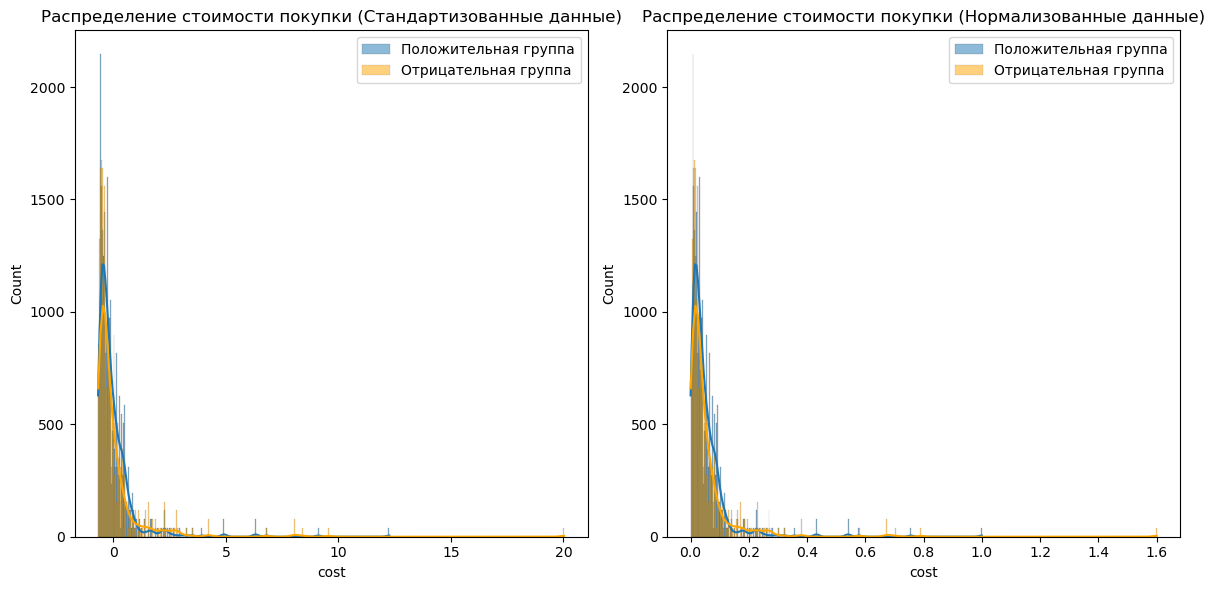

In [35]:
# --- Визуализация ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_positive_scaled['cost'], label='Положительная группа', kde=True)
sns.histplot(df_negative_scaled['cost'], label='Отрицательная группа', kde=True, color='orange')
plt.title('Распределение стоимости покупки (Стандартизованные данные)')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_positive_normalized['cost'], label='Положительная группа', kde=True)
sns.histplot(df_negative_normalized['cost'], label='Отрицательная группа', kde=True, color='orange')
plt.title('Распределение стоимости покупки (Нормализованные данные)')
plt.legend()

plt.tight_layout()
plt.show()

# --- Бизнес-рекомендации ---

Мы наблюдаем положительную динамику в увеличении конверсии и привлечении новых клиентов, что говорит об эффективности нашей маркетинговой кампании. Однако, средний чек остался неизменным или даже снизился, несмотря на увеличение количества транзакций. Статистически значимое различие в среднем чеке после запуска кампании подтверждает, что она оказала существенное влияние на поведение клиентов, и это влияние требует корректировки. В текущей ситуации кампания привлекает больше клиентов, но они тратят меньше в среднем. Это может нивелировать положительный эффект от увеличения конверсии и негативно влиять на общую прибыльность.

Рекомендация: Пересмотр предложений для увеличения среднего чека

Цель: Увеличить среднюю сумму, которую тратит каждый клиент, при этом сохранив или даже улучшив уровень конверсии.

Стратегии и конкретные примеры:

1. Апселлинг (Upselling) и Кросс-селлинг (Cross-selling):
  •  Апселлинг: Предлагайте клиентам более дорогие или премиальные версии выбранного ими товара или услуги.
    *  Пример: Покупка велосипеда

•  Исходная ситуация: Клиент выбирает базовый горный велосипед за 25 000 рублей.
  •  Вариант 1 (Более продвинутый велосипед): "Этот велосипед идеально подходит для прогулок по городу и легкого бездорожья. Но если вы планируете кататься по более сложным трассам и участвовать в гонках, я бы порекомендовал вам модель Y за 35 000 рублей. У нее более легкая рама, улучшенная амортизация и более надежные переключатели, что позволит вам уверенно преодолевать любые препятствия." (Улучшенные компоненты и характеристики)
  •  Вариант 2 (Велосипед с электроприводом): "Вы ищете отличное средство передвижения для города и активного отдыха. Позвольте предложить вам рассмотреть электровелосипед той же модели за 55 000. С ним вы сможете с легкостью преодолевать подъемы и проезжать большие расстояния, не уставая. Это отличное вложение в комфорт и удовольствие от катания." (Дополнительные преимущества электропривода)
  •  Кросс-селлинг: Предлагайте сопутствующие товары или услуги, которые дополняют основную покупку.
    *  Пример: Покупка велосипеда

•  Исходная ситуация: Клиент покупает велосипед.
  •  Предложение 1: "К велосипеду обязательно нужен шлем, чтобы обеспечить безопасность во время катания. У нас есть разные модели на любой вкус и бюджет." (Безопасность)
  •  Предложение 2: "Для комфортных поездок, особенно на дальние расстояния, рекомендуем приобрести велоочки и велоперчатки. Они защитят ваши глаза от солнца и ветра, а руки от натирания." (Комфорт)
  •  Предложение 3: "Для ремонта велосипеда в дороге, вам пригодится набор инструментов, насос и запасная камера. Это поможет вам справиться с небольшими поломками самостоятельно." (Практичность и подготовленность)
  •  Предложение 4: "Для защиты велосипеда от кражи, рекомендуем приобрести надежный велозамок. У нас есть замки разных типов и уровней защиты." (Безопасность имущества)
  •  Предложение 5: "Для удобства хранения и обслуживания велосипеда, предлагаем напольную стойку и набор для чистки цепи." (Удобство и уход)

2. Акционные предложения "Купи больше, заплати меньше":
  •  Разработайте акционные предложения, стимулирующие клиентов к покупке большего количества товаров.
    *  Пример: "Купи 2 футболки, получи третью в подарок!", "При покупке двух товаров - скидка 20% на всю корзину!", "Купите 3 месяца подписки и получите месяц в подарок!".
  •  Многоуровневые акции: Создайте несколько уровней скидок, в зависимости от суммы покупки.
    *  Пример:
      *  Покупка от 1000 руб. - скидка 5%
      *  Покупка от 3000 руб. - скидка 10% + бесплатная доставка
      *  Покупка от 5000 руб. - скидка 15% + бесплатная доставка + подарок

3. Комплексные предложения и пакеты:
  •  Собирайте товары или услуги в тематические комплексы и предлагайте их по более выгодной цене, чем при покупке по отдельности.
    *  Пример: "Набор для пикника: мангал, шампуры, уголь, жидкость для розжига - всего за [цена], что на 10% дешевле, чем покупать по отдельности!".
    *  Пример (для услуг): Пакет "Новичок в беге"

•  Целевая аудитория: Люди, которые только начинают заниматься бегом.

•  Состав пакета:

  •  Индивидуальная консультация с тренером: Оценка физической формы, постановка целей, разработка индивидуального плана тренировок (1 час).
  •  Подбор обуви для бега: Помощь в выборе подходящих кроссовок с учетом типа стопы, техники бега и особенностей местности (30 минут).
  •  Видеоанализ техники бега: Запись бега на беговой дорожке и разбор ошибок с тренером (30 минут).
  •  Комплект носков для бега: 3 пары специальных носков, обеспечивающих комфорт и отвод влаги.
  •  Бесплатный доступ к онлайн-курсу "Основы правильного бега": Видео-уроки по технике бега, разминке, заминке, питанию и предотвращению травм.

•  Цена: 8 000 рублей (при покупке по отдельности стоимость услуг и товаров составила бы 10 000 рублей).

4. Товары с более высокой ценой:
  •  Активно продвигайте товары с более высокой маржинальностью и более высокой ценой.
    *  Пример: Обучайте продавцов, как представлять преимущества премиальных товаров. Отображайте товары более высокой ценовой категории на видных местах на сайте или в магазине. Предлагайте премиальные товары в рекламных кампаниях (например, "Почувствуйте роскошь с нашей новой коллекцией...").

5. Бесплатная доставка при достижении определенной суммы заказа:
  •  Установите минимальную сумму заказа для бесплатной доставки. Это мотивирует клиентов добавлять больше товаров в корзину, чтобы воспользоваться этой выгодой.
    *  Пример: "Бесплатная доставка при заказе от 2000 рублей!".

6. Персонализированные рекомендации:
  •  Используйте данные о предыдущих покупках и предпочтениях клиентов, чтобы предлагать им релевантные товары и услуги, которые могут увеличить средний чек.
    *  Пример: "Пользователям, купившим [товар А], также интересно [товар Б]".

Анализ и мониторинг:

•  Внедрите инструменты аналитики для отслеживания изменения среднего чека, конверсии, и продаж по каждому из предложенных акционных и комплексных предложений.
•  Проводите A/B тестирование различных предложений, чтобы определить наиболее эффективные стратегии.
•  Регулярно анализируйте результаты и вносите корректировки в предложения, чтобы максимизировать их эффективность.

Важно:

•  Убедитесь, что предлагаемые товары и услуги соответствуют интересам и потребностям вашей целевой аудитории.
•  Четко и убедительно доносите ценность ваших предложений до клиентов.
•  Обеспечьте высокий уровень обслуживания клиентов, чтобы повысить их лояльность и стимулировать повторные покупки.

Следуя этим рекомендациям и постоянно анализируя результаты, вы сможете увеличить средний чек и максимизировать прибыль от вашей маркетинговой кампании, используя привлеченных клиентов максимально эффективно. Статистическое подтверждение изменения среднего чека после внедрения этих рекомендаций будет являться ключевым показателем успеха.

# 2. Кластеры

Также выясните, на какие кластеры разбивается аудитория, и предложите методы работы с каждым кластером. Обратите внимание, что количество кластеров необходимо выбрать самостоятельно. В итоговом анализе должна содержаться информация о том, какие товары предпочитают различные кластеры клиентов и насколько на покупку влияет наличие скидки. Если работа некоторых методов занимает слишком много времени, рекомендуем взять случайную выборку строк из датасета (например, 100 000 строк) и построить кластеризацию на её основе.

In [2]:
# Читаем CSV-файл в DataFrame
df = pd.read_csv('final.csv')
df

,id,gender,age,education,city,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
0,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,"велосипед горный женский stern mira 2.0 26""",белый_синий,13599,0.0,1,7
1,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,стол outventure,зелёный,1499,2.0,0,37
2,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,набор outventure: стол + 4 стула,бежевый,4799,2.0,0,37
3,4,0.0,35,0,1134,4.569378,0.063693,0.820892,0.5072,роликовые коньки детские roces orlando iii,черный_розовый,9199,2.0,0,0
4,4,0.0,35,0,1134,4.569378,0.063693,0.820892,0.5072,шлем fila nrk fun,белый,4999,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30387274,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,поло мужское outventure,синий,1599,1.0,0,24
30387275,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,майка мужская babolat complete muscle,оранжевый_синий,3899,1.0,0,24
30387276,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,майка мужская protest prtihiaka,белый_принт,1679,1.0,1,49
30387277,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,массажер demix,темно-зелёный,399,2.0,0,52


In [3]:
# 0. Определение размера выборки
SAMPLE_SIZE = 100000  # Размер выборки
USE_SAMPLE = True  # Переключатель для использования выборк

## Подготовка данных

In [4]:
# 1. Подготовка данных
# a. Выбор признаков для кластеризации (исходный набор)
features = ['gender', 'age', 'education', 'city', 'personal_coef', 'cost', 'product_sex', 'base_sale']

# b. Создание копии данных для выборки
if USE_SAMPLE and len(df) > SAMPLE_SIZE:
    df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).copy()
    X = df_sample[features]  # используем исходные признаки
    df_to_cluster = df_sample
    print(f"Используем выборку из {SAMPLE_SIZE} строк для кластеризации.")
else:
    X = df[features] # используем исходные признаки
    df_to_cluster = df
    print("Используем полный набор данных для кластеризации.")



# c. Масштабирование признаков (для silhouette и elbow)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Масштабируем исходные признаки
X_scaled_df = pd.DataFrame(X_scaled, columns=features) # Используем имена исходных признаков

Используем выборку из 100000 строк для кластеризации.


## Определение оптимального количества кластеров

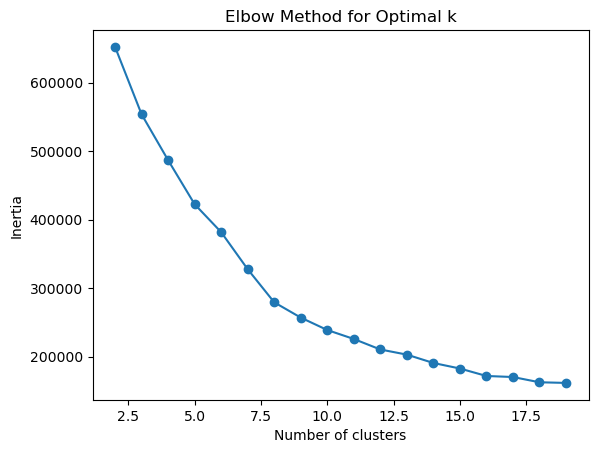

In [5]:
# 2. Определение оптимального количества кластеров

# Метод локтя (Elbow Method)
inertia = []
range_n_clusters = range(2, 20)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

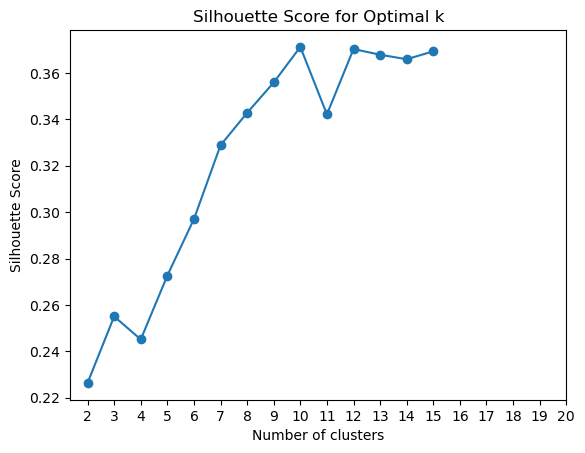

In [6]:
# Silhouette Score
range_n_clusters = range(2, 16)
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    silhouette_scores.append(silhouette_score(X_scaled_df, kmeans.labels_))

plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.xticks(range(2, 21))  # Отображение всех значений на оси x
plt.show()

## Кластеризация

In [7]:
# 3. Кластеризация и добавление меток кластеров

n_clusters = 10  # Замените на оптимальное количество кластеров, определенное по графикам

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

# Обучение и предсказание кластеров
clusters = kmeans.fit_predict(X_scaled_df)

# Добавление меток кластеров в исходный dataframe
if USE_SAMPLE and len(df) > SAMPLE_SIZE:
  df['cluster'] = np.nan # Инициализация столбца кластеров
  df.loc[df_sample.index, 'cluster'] = clusters # Добавление меток кластеров на основе индексов выборки

else:
    df['cluster'] = clusters

In [8]:
#4. Анализ кластеров

#Размер кластеров
print(df['cluster'].value_counts())

#Агрегированные характеристики кластеров
cluster_summary = df.groupby('cluster')[['age', 'personal_coef', 'cost', 'base_sale', 'gender', 'education', 'city']].mean()
print(cluster_summary)

#Анализ предпочтений товаров (пример)
#Самые популярные товары в каждом кластере
for cluster in range(n_clusters):
    print(f"Кластер {cluster}:")
    try:
        top_products = df[df['cluster'] == cluster]['product'].value_counts().nlargest(5)
        print(top_products)
    except KeyError as e:
        print(f"Ошибка KeyError: {e}.  Убедитесь, что столбец 'product' существует.")



#Влияние скидки на покупку в разных кластерах
for cluster in range(n_clusters):
    print(f"Кластер {cluster}:")
    discount_effect = df[df['cluster'] == cluster].groupby('base_sale')['cost'].mean()
    print(discount_effect)


cluster
1.0    26325
4.0    14300
9.0    13010
6.0    11907
2.0    10293
3.0    10087
5.0     5361
0.0     4696
7.0     2789
8.0     1232
Name: count, dtype: int64
               age  personal_coef          cost  base_sale    gender  \
cluster                                                                
0.0      28.276405       0.552409   4329.389693   0.379898  0.000000   
1.0      41.837569       0.433647   5420.123191   0.000000  1.000000   
2.0      43.239289       0.502682   3355.939182   1.000000  0.000291   
3.0      26.489938       0.473641   5273.297313   0.323684  1.000000   
4.0      41.343916       0.501922   3217.469930   0.300070  0.000000   
5.0      15.551576       0.272708   5171.139526   0.360381  0.684387   
6.0      43.766356       0.501349   5039.194927   0.000000  0.051734   
7.0      40.065256       0.463936   4847.558265   0.371459  0.552886   
8.0      37.155844       0.443395  70695.003247   0.053571  0.798701   
9.0      41.942967       0.438101   4085.682

## Визуализация кластеров с помощью PCA

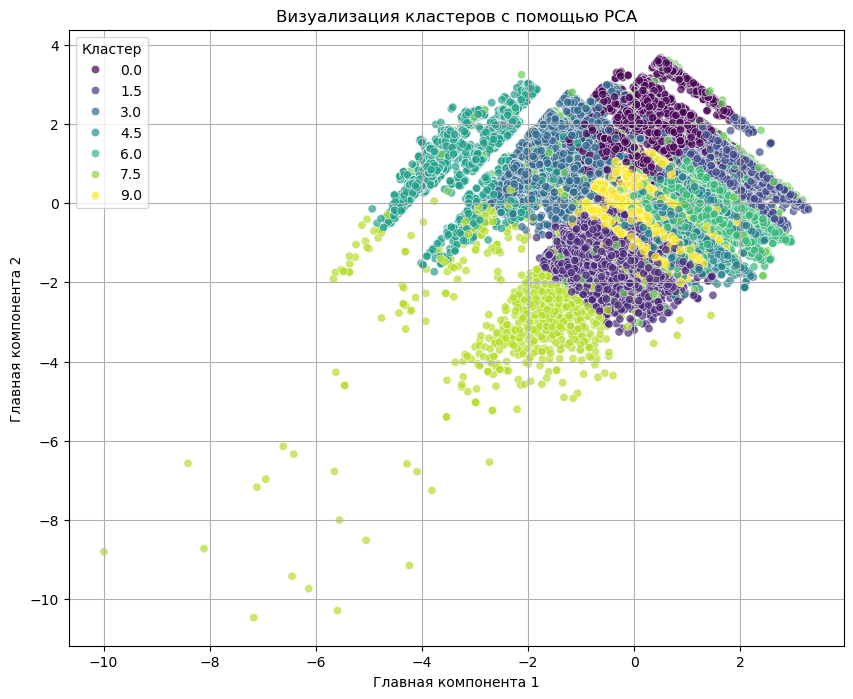

Объясненная доля дисперсии: [0.24635952 0.16747612]
Первая главная компонента объясняет 0.25% дисперсии.
Вторая главная компонента объясняет 0.17% дисперсии.
Вместе они объясняют 0.41% дисперсии.
Внимание: Две главные компоненты объясняют относительно небольшую долю дисперсии.  Визуализация может не полностью отражать структуру исходных данных.

Вклад признаков в PC1:
gender: -0.483
age: 0.471
education: -0.400
city: -0.013
personal_coef: 0.516
cost: -0.150
product_sex: -0.267
base_sale: 0.156

Вклад признаков в PC2:
gender: -0.310
age: -0.481
education: 0.540
city: -0.006
personal_coef: 0.188
cost: -0.239
product_sex: -0.370
base_sale: 0.390


In [12]:
# 5. Визуализация кластеров с помощью PCA

# Подготовка данных для PCA (используем масштабированные данные ДЛЯ ВИЗУАЛИЗАЦИИ)
# Используем ВСЕ признаки, которые были использованы для кластеризации
pca_data = X_scaled_df.copy()  # Используем уже масштабированные данные

# Применение PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pca_data)

# Создаем DataFrame с правильным индексом
if USE_SAMPLE and len(df) > SAMPLE_SIZE:
    pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'], index=df_sample.index)
else:
    pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'], index=df.index)

pca_df['cluster'] = df['cluster']  # Добавляем информацию о кластерах

# Визуализация PCA с использованием seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью PCA')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.legend(title='Кластер')
plt.grid(True)
plt.show()

# Объясненная дисперсия
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Объясненная доля дисперсии: {explained_variance_ratio}")

# Интерпретация объясненной дисперсии
total_explained_variance = sum(explained_variance_ratio)
print(f"Первая главная компонента объясняет {explained_variance_ratio[0]:.2f}% дисперсии.")
print(f"Вторая главная компонента объясняет {explained_variance_ratio[1]:.2f}% дисперсии.")
print(f"Вместе они объясняют {total_explained_variance:.2f}% дисперсии.")

if total_explained_variance < 0.6:
    print("Внимание: Две главные компоненты объясняют относительно небольшую долю дисперсии.  Визуализация может не полностью отражать структуру исходных данных.")

# Добавляем информацию о вкладе признаков
feature_names = X_scaled_df.columns  # Имена исходных признаков

# Выводим информацию о вкладе признаков в PC1 и PC2
print("\nВклад признаков в PC1:")
for feature, weight in zip(feature_names, pca.components_[0]):
    print(f"{feature}: {weight:.3f}")

print("\nВклад признаков в PC2:")
for feature, weight in zip(feature_names, pca.components_[1]):
    print(f"{feature}: {weight:.3f}")

# Общие наблюдения

•  Размер кластеров разный: Некоторые группы покупателей (кластеры) гораздо больше других. Например, кластер 5 - самый большой, а кластеры 3, 4 и 7 - очень маленькие.
•  Различия по полу: В некоторых группах больше мужчин или женщин.
•  Различия по возрасту: Средний возраст покупателей сильно отличается в разных группах.
•  Различия по стоимости товаров: Средняя стоимость покупок в разных группах значительно отличается.
•  Различия по образованию: Средний уровень образования сильно отличается в разных кластерах.

Разбор кластеров (групп покупателей):

•  Кластер 0 (Размер: 22137): Одежда Demix

  •  Характеристики: Относительно молодые (средний возраст 31,5 года), немного больше женщин (около 59%), средняя стоимость товаров.
  •  Популярные товары: В основном одежда Demix (шорты, брюки, футболки) и немного брюк Outventure.
  •  Интерпретация: Это покупатели, которые экономят и покупают недорогую спортивную одежду Demix и Outventure. Скорее всего, это молодые люди, которым важна доступность.

•  Кластер 1 (Размер: 18586): Спортивная одежда и активный образ жизни

  •  Характеристики: Более старшие (средний возраст 49,3 года), примерно одинаковое количество мужчин и женщин (51% женщин), средняя стоимость товаров.
  •  Популярные товары: Женское белье (вероятно, спортивное), одежда Demix и Outventure.
  •  Интерпретация: Это группа покупателей старшего возраста, интересующихся спортом и активным образом жизни, выбирающих спортивную одежду Demix и Outventure, а также спортивное женское белье Joss.

•  Кластер 2 (Размер: 3518): Дорогая городская и спортивная одежда

  •  Характеристики: Очень молодые (средний возраст 28,6 лет), больше женщин (около 72%), очень высокая стоимость товаров. Низкий базовый объем продаж.
  •  Популярные товары: Дорогие кроссовки (Nike Air Force 1, New Balance 574) и горные велосипеды Stern Energy.
  •  Интерпретация: Молодые, платежеспособные покупатели, интересующиеся модой и популярными товарами.

•  Кластер 3 (Размер: 255): Очень дорогие велосипеды и товары для спорта

  •  Характеристики: Средний возраст (36,9 лет), больше женщин (около 78%), очень высокая стоимость товаров.
  •  Популярные товары: Велотренажеры Elite, шоссейные велосипеды Scott, дорогие палатки.
  •  Интерпретация: Небольшая группа серьезных велосипедистов и любителей активного отдыха, готовых тратить много денег на качественное оборудование.

•  Кластер 4 (Размер: 1137): Дорогие велосипеды и фитнес

  •  Характеристики: Средний возраст (36,9 лет), больше женщин (около 76%), очень высокая стоимость товаров.
  •  Популярные товары: Электровелосипеды, куртки Arc'teryx, горные велосипеды Stern Force и Trek Marlin, силовые тренажеры.
  •  Интерпретация: Еще одна группа любителей фитнеса и активного отдыха, готовых тратить значительные суммы на качественное оборудование.

•  Кластер 5 (Размер: 27497): Одежда Demix

  •  Характеристики: Средний возраст (39,6 лет), примерно одинаковое количество мужчин и женщин (49% женщин), средняя стоимость товаров.
  •  Популярные товары: В основном одежда Demix (шорты, брюки, футболки) и Joss.
  •  Интерпретация: Похожа на кластер 0, но с немного более старшей аудиторией. Покупают спортивную одежду Demix и спортивное женское белье Joss.

•  Кластер 6 (Размер: 14269): Бюджетный активный образ жизни

  •  Характеристики: Очень молодые (средний возраст 19,9 лет), больше женщин (около 69%), средняя стоимость товаров. Высокий уровень образования.
  •  Популярные товары: Футболки Demix, сабо Crocs.
  •  Интерпретация: Студенты или молодые люди, покупающие недорогую спортивную одежду и обувь.

•  Кластер 7 (Размер: 19): Очень дорогие товары для активного отдыха

  •  Характеристики: Средний возраст (35,3 года), в основном женщины (около 89%), ×очень× высокая стоимость товаров. Базовые продажи = 0.
  •  Популярные товары: Очень дорогие горные велосипеды Merida, беговые дорожки NordicTrack, дорогие эхолоты.
  •  Интерпретация: Очень маленькая группа женщин, готовых тратить огромные деньги на нишевые товары для спорта и отдыха.

•  Кластер 8 (Размер: 8522): Базовая спортивная одежда

  •  Характеристики: Старшие (средний возраст 61,5 года), примерно одинаковое количество мужчин и женщин (51% женщин), средняя стоимость товаров.
  •  Популярные товары: Одежда Demix и Outventure.
  •  Интерпретация: Покупатели старшего возраста, которым нужна базовая спортивная и туристическая одежда Demix и Outventure.

•  Кластер 9 (Размер: 4060): Кроссовки New Balance и Nike

  •  Характеристики: Средний возраст (45,9 лет), больше женщин (около 66%), высокая стоимость товаров.
  •  Популярные товары: Кроссовки New Balance 574, Nike Air Max 270.
  •  Интерпретация: Покупатели, интересующиеся модной повседневной обувью.

Рекомендации:

•  Целевой маркетинг: Настройте рекламные кампании с учетом интересов и характеристик каждой группы покупателей.
•  Рекомендации товаров: Используйте данные о кластерах, чтобы рекомендовать товары, которые будут интересны конкретным покупателям.
•  Ценообразование: Учитывайте, насколько чувствительны к цене покупатели в каждой группе.
•  Управление запасами: Следите за тем, чтобы на складе всегда было достаточно популярных товаров для каждой группы.
•  Демографический фокус: Учитывайте различия в образовании между кластерами при проведении маркетинговых кампаний.

# 3 Модель склонности клиента к покупке.

Также интересует информация о жителях страны 32 города 1 188: именно на них планируется запуск новой маркетинговой кампании. Постройте модель склонности клиента к покупке определённого товара при коммуникации, основанную на данных о профилях клиентов, данных товаров и данных о прошлых маркетинговых кампаниях.

## Чтение CSV-файла

In [44]:
# Читаем CSV-файл в DataFrame
df = pd.read_csv('final.csv')
df

,id,gender,age,education,city,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt
0,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,"велосипед горный женский stern mira 2.0 26""",белый_синий,13599,0.0,1,7
1,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,стол outventure,зелёный,1499,2.0,0,37
2,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,набор outventure: стол + 4 стула,бежевый,4799,2.0,0,37
3,4,0.0,35,0,1134,4.569378,0.063693,0.820892,0.5072,роликовые коньки детские roces orlando iii,черный_розовый,9199,2.0,0,0
4,4,0.0,35,0,1134,4.569378,0.063693,0.820892,0.5072,шлем fila nrk fun,белый,4999,2.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30387274,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,поло мужское outventure,синий,1599,1.0,0,24
30387275,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,майка мужская babolat complete muscle,оранжевый_синий,3899,1.0,0,24
30387276,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,майка мужская protest prtihiaka,белый_принт,1679,1.0,1,49
30387277,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,массажер demix,темно-зелёный,399,2.0,0,52


## Подготовка данных и разбивка по категориям

In [45]:
num_unique_products = df['product'].nunique()

print(f"Количество уникальных товаров: {num_unique_products}")

Количество уникальных товаров: 22769


In [46]:
unique_products = df['product'].unique().tolist()

# unique_products теперь содержит список всех уникальных названий товаров


#  Сохранение списка в файл
with open('unique_products.txt', 'w', encoding='utf-8') as f:
    for product in unique_products:
      f.write(product + '\n')

In [47]:

categories = {
    'Одежда': ['куртка', 'футболка', 'носки', 'джемпер', 'брюки', 'гетры', 'платье', 'майка', 'худи', 'ветровка', 'купальник', 'плавки', 'рашгард', 'олимпийка', 'шорты ', 'лиф', 'лонгслив', 'бомбер', 'костюм', 'свитшот', 'бриджи', 'плавки-шорты', 'трусы', 'толстовка', 'рубашка', 'борцовки', 'жилет', 'легинсы', 'юбка', 'туника', 'анорак', 'пуховик', 'трико', 'термобелья', 'велосипедки', 'топ', 'велошорты', 'юбка-шорты ', 'бра', 'пальто', 'windbreaker', 'bra', 'top', 'jumpsuit', 'tshirt', 'бикини', 'боди', 'топ-бра', 'trousers', 'брюки-самосбросы', 'брюки-шорты', 'socks', 'бордшорты', 'варежки', 'водолазка', 'гамаши', 'пончо', 'джерси', 'добок', 'дождевик', 'форма', 'кальсоны', 'кимоно', 'комбинезон', 'формы', 'костюм-сауна', 'купальный', 'куртка-анорак', 'лиф', 'манишка', 'джаммеры', 'парка', 'поло', 'полукомбинезон', 'полупальто', 'пояс', 'свитер', 'снуд', 'тайтсы', 'толстовка', 'шарф', 'шингарты'],
    'Обувь': ['кроссовки', 'кеды', 'ботинки', 'бутсы', 'сандалии', 'слипоны', 'балетки', 'полуботинки', 'сабо', 'шлепанцы', 'сапоги', 'туфли', 'эспадрильи', 'shoes', 'sneakers', 'боксерки', 'joss', 'termit', 'велоботинки', 'велообувь', 'джазовки', 'мокасины', 'полусапоги', 'получешки', 'сороконожки', 'тапочки', 'чешки'],
    'Головные уборы': ['бейсболка', 'шапка', 'панама', 'гейтор', 'повязка', 'шапочка', 'бандана', 'балаклава', 'бейсболки', 'кепка', 'козырек'],
    'Инвентарь': ['лестница', 'мяч', 'ворота', 'фишки', 'палки', 'ракетка', 'бутылка', 'гантель', 'иоги', 'скамья', 'бафф', 'бита', 'блин', 'щетка', 'булавы', 'бумеранг', 'ball', 'kлюшка', 'бакл', 'бакля', 'барабан', 'бодибар', 'буксир', 'лиш', 'бушинги', 'велокресло', 'веломаска', 'велостанок', 'весло', 'ветряк', 'визор', 'волан', 'волейбольная', 'гантели', 'гейтор', 'гимнастические', 'тренажер', 'гиря', 'груша', 'комплекс', 'дротики', 'зажим', 'имитатор', 'канат', 'капа', 'клюшка', 'колобашка', 'кольца', 'команда', 'комлект', 'компас', 'tusa', 'лыжный', 'конусы', 'лапа', 'лапы', 'лента', 'липучки', 'макивара', 'массажный', 'мат', 'мишень', 'ледянка', 'мячи', 'воланов', 'эспандеров', 'тенниса', 'бадминтона', 'колышков', 'дротиков', 'мячей', 'оперений', 'конусов', 'планок', 'хвостовиков', 'лент', 'эспандеров', 'накладка', 'накладки', 'наконечники', 'настольный', 'оперения', 'основание', 'парус', 'подставка', 'ролик', 'сетка', 'скребок', 'трубка', 'турник', 'тюбинг', 'упоры', 'утяжелители', 'фрисби', 'шайба', 'эспандер', 'эспандер-лента'],
    'Комплектующие': ['ремонтный', 'покрышка', 'крыльев', 'подножка', 'чехлы', 'крепление', 'игла', 'флягодержатель', 'звонок', 'подножка', 'наборных', 'колес', 'крепления', 'стойки', 'колесо', 'втулка', 'монтажек', 'тормозные', ' шатунов' , 'крыло', 'цепь', 'cмазка', 'адаптер', 'багажник', 'колеса', 'блок', 'брусья', 'брызговики', 'адаптеры', 'болты', 'велокрепление', 'велопедали', 'вилка', 'винт', 'выжимка', 'вынос', 'гидролиния', 'грипса', 'грипсы', 'гриф', 'гудок', 'датчик', 'декоративные', 'декоративный', 'держатели', 'держатель', 'диски', 'жердь', 'заглушки', 'переключатель', 'тормоз', 'замки', 'замок', 'заплатки', 'запчасть', 'затачиватель', 'затягиватель', 'звезда', 'зеркало', 'инструмент', 'камера', 'канторез', 'карабин', 'каретка', 'клапан', 'ключ', 'колодка', 'колодки', 'колпачки', 'кольцо', 'комборучка', 'корзина', 'кошки', 'крепление', 'крюки', 'лапка', 'линза', 'мазь', 'манжет', 'мультиключ', 'колес', 'крыльев', 'мазей', 'подшипников', 'подножка', 'подседельная', 'покрышка', 'ручка', 'ручки', 'сиденье', 'шатунов', 'струна', 'темляки', 'фартук', 'флексор', 'чехлы', 'чехол', 'шифтер', 'байдарок'],
    'Спортивные товары': ['велосипед', 'коньки', 'диск', 'платформа', 'мини-степпер', 'игра', 'круизер', 'мини-круизер ', 'тренажер', 'cноуборд', 'sup', 'байдарка', 'борд', 'полусфера', 'барьер', 'батут', 'беговел', 'лыжи', 'ласты', 'лопатки', 'лук', 'лыжероллеры', 'скамья', 'обруч', 'роликовые', 'свисток', 'центр', 'скакалка', 'скамья', 'скейтборд', 'снегокат', 'снегоступы', 'скутер', 'сноуборд', 'сноускейт', 'степпер', 'дартс','степ-платформа', 'стойка', 'стрессбол', 'фитнес-коньки ', 'игра', 'медицинбол'],
    'Туризм/рыбалка/охота': ['палатка', 'спальный', 'лодка', 'надувной', 'клапан', 'спиннинг', 'леска', 'матрас', 'нож', 'тент', 'кресло', 'гермосумка', 'посуды', 'термос', 'миска', 'gladiator', 'аккумулятор', 'баллон', 'бассейн', 'горелка', 'эхолот', 'бинокль', 'блесна', 'безмен', 'веревка', 'веревки-растяжки', 'виброхвост', 'вкладыш', 'воблер', 'змей', 'вставка', 'лампа', 'гамак', 'дно', 'дуги', 'душ', 'душ-гермомешок', 'карман', 'удилище', 'кастрюля', 'катамаран', 'катушка', 'качели', 'комбинированная', 'компактный', 'компрессионный', 'коптильня', 'коробка', 'котел', 'котелок', 'круг', 'крючок', 'мангал', 'москитная', 'мультиинструмент', 'посуды', 'приборов', 'нарукавники', 'незацепляйка', 'огниво', 'одеяло', 'плед', 'подушка', 'кораблик', 'решетка-гриль', 'приманка', 'ведро', 'спички', 'стакан ', 'таганок', 'таз', 'тарелка', 'тарзанка', 'твистер', 'тейл', 'тренога', 'чайник', 'червь'],
    'Техника': ['дорожка', 'насос', 'фонарь', 'дорожка', 'фитнес-браслет', 'apple', 'наушники', 'computer', 'li-ion ', 'велокомпьютер', 'велотренажер', 'велоэргометр', 'вентилятор', 'весы', 'виброгасители', 'виброгаситель', 'внешний', 'резак', 'тренажер', 'зарядное', 'кардиодатчик', 'кардиопояс', 'картплоттер', 'радиостанций', 'кофеварка', 'кофемолка', 'манометр', 'мини-велотренажер', 'монитор', 'фонарь', 'наушники', 'станция', 'панель', 'утюг', 'таймер', 'трекер', 'фитнес-браслет', 'часы', 'шагомер','электрический', 'электровелосипед', 'электросамокат'],
    'Мебель': ['стол', 'стул', 'кровать-раскладушка', 'table', 'кухня', ' кровать', 'стул-рюкзак', 'стул-табурет'],
    'Гигиена': ['дезодорант', 'полотенце', 'стирки', 'антибактериальные', 'влажные', 'ухода'],
    'Спортивное питание': ['протеин', 'maxler', 'sis', 'аминокислоты', 'аминокислота', 'батончики', 'батончик', 'кислота', 'bcaa', 'l-carnitine', 'витамин', 'витаминная', 'витаминно-минеральный', 'витамины', 'гейнер', 'энергетический', 'глютамин', 'добавка', 'жиросжигатель', 'сон', 'изотоник', 'казеин', 'карнитин', 'коллаген', 'связок', 'омега', 'креатин', 'л-карнитин', 'магнезия', 'магний', 'мелатонин', 'мюсли', 'напиток', 'печенье', 'панкейк', 'коктейль', 'шоколад ', 'фьюз'],
    'Амуниция': ['шлем', 'защиты', 'рюкзак', 'сумка', 'солнцезащитные', 'очки', 'перчатки', 'гидрокостюм', 'маска', 'рюкзак-жилет', 'баул', 'намотка', 'gloves', 'гермобаул', 'гермомешок', 'герморюкзак', 'гермосумка', 'гермочехол', 'стяжка', 'защита', 'защитный', 'манжета', 'мешок', 'нагрудник', 'наколенник', 'наколенники', 'налокотники', 'напульсник', 'напульсники', 'подсумок', 'подтяжки', 'поясная', 'рукав', 'чемодан', 'щит', 'щитки'], 
    'Аптечка': ['бинт', 'аптечка', 'бактерицидный', 'беруши', 'бинты', 'бандаж', 'гидроколлоидный', 'глюкозамин', 'кинезиотейп', 'суппорт', 'тейп'],
    'Разное': ['батареек', 'пена', 'антифог', 'аэрозоль', 'батарейки', 'краска-ликвид', 'мультиключ', 'браслет', 'кошелек', 'брелок', 'аквагрим', 'банка', 'вкладыши', 'грязеотталкивающее', 'пропитка', 'спрей', 'грелка', 'губка-очиститель', 'крем', 'тактическая', 'древко', 'камус', 'клистер', 'комбо-набор', 'косметичка', 'краска', 'кружка', 'лосьон', 'маркер', 'массажер', 'мультитул', 'накидка', 'наклейки', 'нейтрализатор', 'несессер', 'карта', 'подпяточники', 'ремень', 'сквиш', 'смывка', 'стельки', 'стяжка', 'флаг', 'фляга', 'фляжка', 'шейкер', 'шнурки']
}

def categorize_product(product_name, categories):
    """Возвращает категорию продукта на основе ключевых слов."""
    product_name = product_name.lower()
    for category, keywords in categories.items():
        for keyword in keywords:
            if keyword in product_name:
                return category
    return "Другое"  # Если не найдено соответствий

# Применим функцию категоризации к столбцу 'product'
df['category'] = df['product'].apply(lambda x: categorize_product(x, categories))

print(df[['product', 'category']].head(20)) # Посмотрим первые 20 строк
print(df['category'].value_counts()) # Посмотрим распределение по категориям

                                              product           category
0         велосипед горный женский stern mira 2.0 26"  Спортивные товары
1                                     стол outventure             Мебель
2                    набор outventure: стол + 4 стула             Мебель
3          роликовые коньки детские roces orlando iii          Инвентарь
4                                   шлем fila nrk fun           Амуниция
5             роликовые коньки детские roces yuma tif          Инвентарь
6   набор защиты из 3-х предметов детский reaction...           Амуниция
7                     шлем для девочек reaction urban           Амуниция
8   роликовые коньки детские раздвижные reaction r...          Инвентарь
9            куртка утепленная для девочек outventure             Одежда
10        кроссовки для мальчиков geox j sprintye boy              Обувь
11            кеды мужские reebok royal complete cln2              Обувь
12              футболка мужская kappa authentic co

## Просмотр  датафрема с колонкой разбивки по категориям

In [48]:
df

,id,gender,age,education,city,lbt_coef,ac_coef,sm_coef,personal_coef,product,colour,cost,product_sex,base_sale,dt,category
0,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,"велосипед горный женский stern mira 2.0 26""",белый_синий,13599,0.0,1,7,Спортивные товары
1,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,стол outventure,зелёный,1499,2.0,0,37,Мебель
2,0,0.0,36,0,1201,5.078678,-0.307147,0.959027,0.5072,набор outventure: стол + 4 стула,бежевый,4799,2.0,0,37,Мебель
3,4,0.0,35,0,1134,4.569378,0.063693,0.820892,0.5072,роликовые коньки детские roces orlando iii,черный_розовый,9199,2.0,0,0,Инвентарь
4,4,0.0,35,0,1134,4.569378,0.063693,0.820892,0.5072,шлем fila nrk fun,белый,4999,2.0,0,0,Амуниция
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30387274,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,поло мужское outventure,синий,1599,1.0,0,24,Одежда
30387275,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,майка мужская babolat complete muscle,оранжевый_синий,3899,1.0,0,24,Одежда
30387276,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,майка мужская protest prtihiaka,белый_принт,1679,1.0,1,49,Одежда
30387277,15885,0.0,33,0,1190,7.321749,0.470877,0.699928,0.4304,массажер demix,темно-зелёный,399,2.0,0,52,Разное


## Удаление "лишних" колонок

In [49]:
df.drop(['lbt_coef', 'ac_coef', 'sm_coef', 'product', 'colour'], axis=1, inplace=True)
df   

,id,gender,age,education,city,personal_coef,cost,product_sex,base_sale,dt,category
0,0,0.0,36,0,1201,0.5072,13599,0.0,1,7,Спортивные товары
1,0,0.0,36,0,1201,0.5072,1499,2.0,0,37,Мебель
2,0,0.0,36,0,1201,0.5072,4799,2.0,0,37,Мебель
3,4,0.0,35,0,1134,0.5072,9199,2.0,0,0,Инвентарь
4,4,0.0,35,0,1134,0.5072,4999,2.0,0,0,Амуниция
...,...,...,...,...,...,...,...,...,...,...,...
30387274,15885,0.0,33,0,1190,0.4304,1599,1.0,0,24,Одежда
30387275,15885,0.0,33,0,1190,0.4304,3899,1.0,0,24,Одежда
30387276,15885,0.0,33,0,1190,0.4304,1679,1.0,1,49,Одежда
30387277,15885,0.0,33,0,1190,0.4304,399,2.0,0,52,Разное


## Загрузка ID пользователей, участвовавших в первой кампании

In [50]:
# Загрузка ID пользователей, участвовавших в первой кампании
try:
    with open("ids_first_company_positive.txt", "r") as f:
        f.readline()  # Пропускаем первую строку (заголовок)
        line = f.readline()  # Читаем вторую строку (с ID)
        line = line.replace(';', ',')  # Заменяем точки с запятой на запятые
        ids_first_company = [int(id.strip()) for id in line.split(',') if id.strip()]
except FileNotFoundError:
    print("Файл ids_first_company_positive.txt не найден!")
    ids_first_company = []

## Создание целевой переменной

In [51]:
# 2. Создание целевой переменной (target variable) 
user_purchase_counts = df['id'].value_counts()  # Вычисляем количество покупок для каждого пользователя один раз
average_purchases = user_purchase_counts.mean()   # Вычисляем среднее количество покупок

# Используем Series.map для создания столбца 'target'
df['target'] = df['id'].map(lambda x: 1 if user_purchase_counts.get(x, 0) > average_purchases else 0)

## Добавление информации о маркетинговых кампаниях

In [52]:
# 3. Добавление информации о маркетинговых кампаниях

# Кампания 1: Персональные скидки по email
df['campaign_1'] = df['id'].apply(lambda x: 1 if x in ids_first_company else 0) #1 если участвовал, 0 - нет

# Кампания 2: Баннерная реклама для жителей города 1134
df['campaign_2'] = ((df['city'] == 1134) & ((df['dt'] == 15) | (df['dt'] == 45))).astype(int) # 1 если участвовал, 0 - нет

# Кампания 3: новая кампания на пользователей из города 1 188
df['campaign_3'] = (df['city'] == 1188).astype(int) # 1 если из города 1188, 0 - нет

## Подготовка данных для обучения модели

In [53]:
# 4. Подготовка данных для обучения модели

# Выбор обучающей выборки: пользователи, участвовавшие в кампаниях 1 и 2.
train_df = df[df['campaign_1'] == 1]
train_df = pd.concat([train_df, df[df['campaign_2'] == 1]], ignore_index=True) #добавили всех из второй кампании

# Выбор признаков для обучения
features = ['gender', 'age', 'education', 'city', 'personal_coef', 'cost', 'product_sex', 'base_sale', 'dt'] #убрали id & category

# Разделение на признаки (X) и целевую переменную (y)
X = train_df[features]
y = train_df['target']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

##  Обучение модели

In [54]:
# 5. Обучение модели

# Создание модели RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42) #параметр n_estimators регулирует кол-во деревьев

# Обучение модели
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

##  Оценка модели

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     43323
           1       0.97      0.98      0.97     79566

    accuracy                           0.96    122889
   macro avg       0.96      0.96      0.96    122889
weighted avg       0.96      0.96      0.96    122889



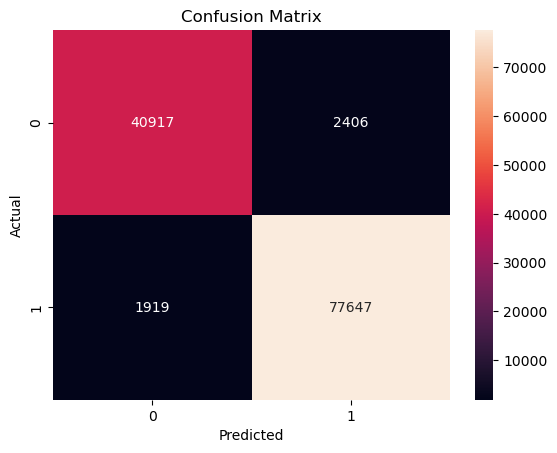

In [55]:
# 6. Оценка модели

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Оценка результатов классификации
print(classification_report(y_test, y_pred))

# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Анализ склонности к покупке различных категорий для жителей города 1188 (новая кампания)

Склонность к покупке категорий для жителей города 1188:
category_purchases
Спортивное питание      0.711791
Другое                  0.691099
Мебель                  0.687420
Обувь                   0.680693
Головные уборы          0.676205
Амуниция                0.675868
Техника                 0.668144
Одежда                  0.666381
Туризм/рыбалка/охота    0.659607
Комплектующие           0.656326
Инвентарь               0.651425
Спортивные товары       0.644559
Разное                  0.626748
Аптечка                 0.621311
Гигиена                 0.442941
Name: predicted_probability, dtype: float64


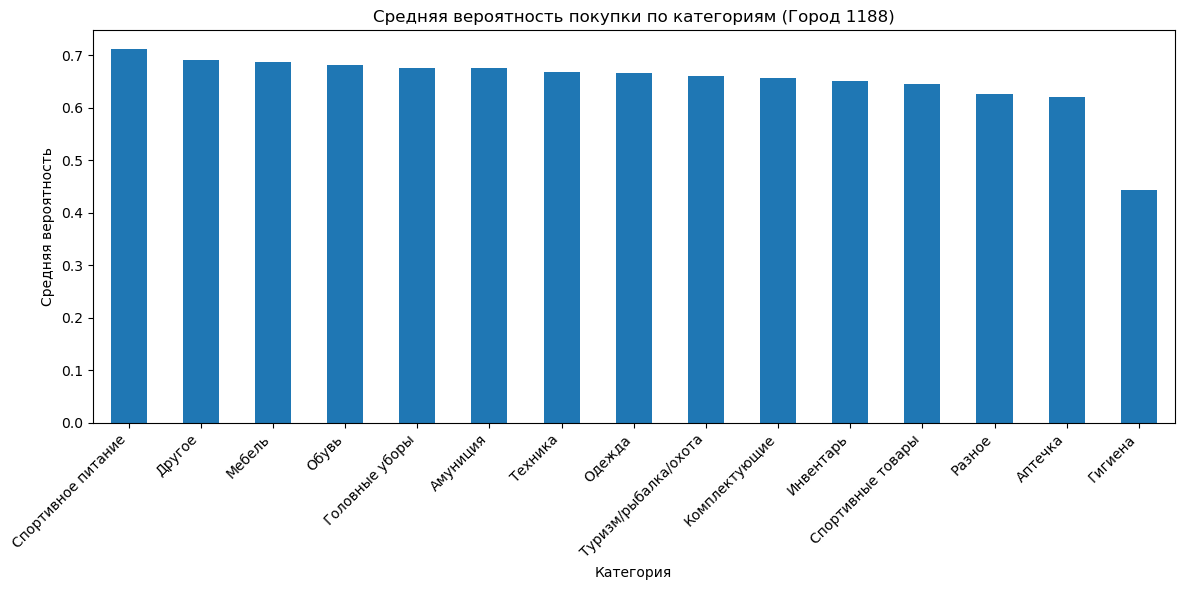

In [56]:
# 7. Анализ склонности к покупке различных категорий для жителей города 1188 (новая кампания)

# Фильтрация данных для жителей города 1188
city_1188_df = df[df['city'] == 1188].copy() #создание копии, чтобы избежать предупреждений

# Предсказание вероятности покупки для каждого жителя города 1188
city_1188_df['predicted_probability'] = model.predict_proba(city_1188_df[features])[:, 1] #вероятность класса "1"

# 1. Создаем словарь соответствия user_id -> category (только для city_1188)
user_category_map = df[df['city'] == 1188].groupby('id')['category'].first().to_dict()

# 2. Применяем словарь для быстрого получения категорий
city_1188_df['category_purchases'] = city_1188_df['id'].map(user_category_map)

# Группировка по категориям и расчет средней вероятности
category_probabilities = city_1188_df.groupby('category_purchases')['predicted_probability'].mean().sort_values(ascending=False) #сортировка по убыванию

# Вывод результатов
print("Склонность к покупке категорий для жителей города 1188:")
print(category_probabilities)

# Визуализация
category_probabilities.plot(kind='bar', figsize=(12, 6))
plt.title('Средняя вероятность покупки по категориям (Город 1188)')
plt.xlabel('Категория')
plt.ylabel('Средняя вероятность')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Вывод наиболее перспективных категорий для таргетинга

In [57]:
# 8. Вывод наиболее перспективных категорий для таргетинга

top_categories = category_probabilities.head(3) #изменил с 5 на 3
print("\nНаиболее перспективные категории для таргетинга в городе 1188:")
print(top_categories)


Наиболее перспективные категории для таргетинга в городе 1188:
category_purchases
Спортивное питание    0.711791
Другое                0.691099
Мебель                0.687420
Name: predicted_probability, dtype: float64


# --- Бизнес-рекомендации ---

•  Фокус на наиболее перспективных категориях:
  •  Спортивное питание: Разработать кампании, ориентированные на здоровый образ жизни, спортивные достижения и удобство использования спортивного питания.
  •  Разное: Увеличить кол-во навесок в ТЗ с минипродукцией из серии "мелочи"
  •  Мебель: Акцент на комфорте, дизайне и функциональности мебели, учитывая возможные предпочтения жителей города.
  •  Обувь и Головные уборы: Подчеркнуть стиль, качество и соответствие сезону. Рассмотреть коллаборации с местными дизайнерами или блогерами.
  •  Амуниция: Если город имеет отношение к спорту, охоте или рыбалке, предложить специализированную амуницию высокого качества.

•  Персонализация:
  •  Используйте данные о профилях клиентов (если они доступны) для таргетирования рекламы и предложений.
  •  Сегментируйте аудиторию по интересам (например, любители спорта, домохозяйки, рыбаки) и создавайте персонализированные сообщения для каждого сегмента.
  •  Предлагайте релевантные товары и скидки на основе прошлых покупок и просмотров.

•  Каналы коммуникации:
  •  Определите наиболее эффективные каналы коммуникации с жителями города 1188 (социальные сети, местные СМИ, email-рассылки, наружная реклама и т.д.).
  •  Используйте омниканальный подход, чтобы обеспечить согласованный опыт для клиентов на всех каналах.

•  Стимулирование покупок:
  •  Предлагайте скидки, акции, купоны и другие стимулы для совершения покупок.
  •  Проводите конкурсы и розыгрыши с призами, связанными с ключевыми категориями товаров.
  •  Создавайте программы лояльности для постоянных клиентов.

•  Улучшение представления категории "Гигиена":
  •  Проведите исследование, чтобы понять причины низкой склонности к покупке товаров гигиены.
  •  Возможно, необходимо изменить ассортимент, улучшить качество товаров, предложить более выгодные цены или использовать другие маркетинговые стратегии.
  •  Подчеркните важность гигиены для здоровья и благополучия.

3. Стратегии для города 1188 (с учетом специфики города):

•  Местная специфика: Учитывайте культурные особенности, традиции и события города 1188 при разработке кампаний. Например, если в городе проводится спортивное мероприятие, можно предложить скидки на спортивное питание и одежду.
•  Партнерства: Сотрудничайте с местными предприятиями, организациями и лидерами мнений для продвижения товаров и услуг.
•  Социальная ответственность: Поддерживайте местные благотворительные организации и инициативы, чтобы укрепить связь с сообществом.


В заключение:

Успех маркетинговой кампании в городе 1188 зависит от глубокого понимания потребностей и предпочтений его жителей, а также от использования данных для персонализации предложений и выбора наиболее эффективных каналов коммуникации. Построение модели склонности к покупке позволит более точно таргетировать кампании и максимизировать ROI. Не забывайте адаптировать ваши стратегии к местным условиям и поддерживать связь с сообществом.